# AQREIGHT Computer Vision Technical Assessment
## Applicant's Name : Ahmad Zhafri Hariz Bin Roslan


This notebook will explore and analyse the <b>Flowers102</b> from torchvision datasets. The cell below shows the relevant libraries that will be utilised for the EDA process.

In [2]:
import torch
import torchvision
from torchvision.datasets import Flowers102
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

### 1. Loading imports and exploring the dataset size
The dataset from pytorch has 3 folders; train, validation, and testing. All 3 folders will be used in this assessment. The code below will download the dataset into this notebook. Then length and classes are checked to see all of them have the same class number.

In [3]:
train_dataset = Flowers102(root='./data', download=True)
val_dataset = Flowers102(root='./data', split='val', download=True)
test_dataset = Flowers102(root='./data', split='test', download=True)


100%|██████████| 345M/345M [00:08<00:00, 42.3MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.40MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 37.1MB/s]


In [4]:
print(f"Total class in train dataset: {len(train_dataset.classes)}")
print(f"Total class in validation dataset: {len(val_dataset.classes)}")
print(f"Total class in test dataset: {len(test_dataset.classes)}")
print(f"Total train images: {len(train_dataset)}")
print(f"Total validation images: {len(val_dataset)}")
print(f"Total test images: {len(test_dataset)}")


Total class in train dataset: 102
Total class in validation dataset: 102
Total class in test dataset: 102
Total train images: 1020
Total validation images: 1020
Total test images: 6149


Based on the above output, all 3 dataset contain the same number of classes. However, the number of train images are significantly lower than test images. Perhaps I will need to utilize data augmentation to help the model during training. Data augmentation can create more diverse sample from the training images to generalize better in the test dataset.

### 2. Class distribution
In this section, I am exploring the class distribution to see if there any class imbalances. Class imbalance refers to the one or multiple classes in the dataset has more samples than the other.

In [5]:
img, label = train_dataset[0]
print(f"Image format: {img.format}, Size: {img.size}, Mode: {img.mode}")

Image format: None, Size: (754, 500), Mode: RGB


Class distribution function to extract the labels and plot the distribution.
I am using the Counter class to help with counter the all labels and their respective samples.

In [6]:
# Extract all labels
def display_distribution(dataset,split):
  labels = [label for _, label in dataset]
  counts = Counter(labels)

  # Plot distribution
  plt.figure(figsize=(15, 5))
  plt.bar(counts.keys(), counts.values())
  plt.xlabel("Flower Class ID")
  plt.ylabel("Number of Images")
  plt.title(f"Class Distribution in Flowers102 ({split})")
  plt.show()

  print(f"Min images in a class: {min(counts.values())}")
  print(f"Max images in a class: {max(counts.values())}")

Train dataset class distribution

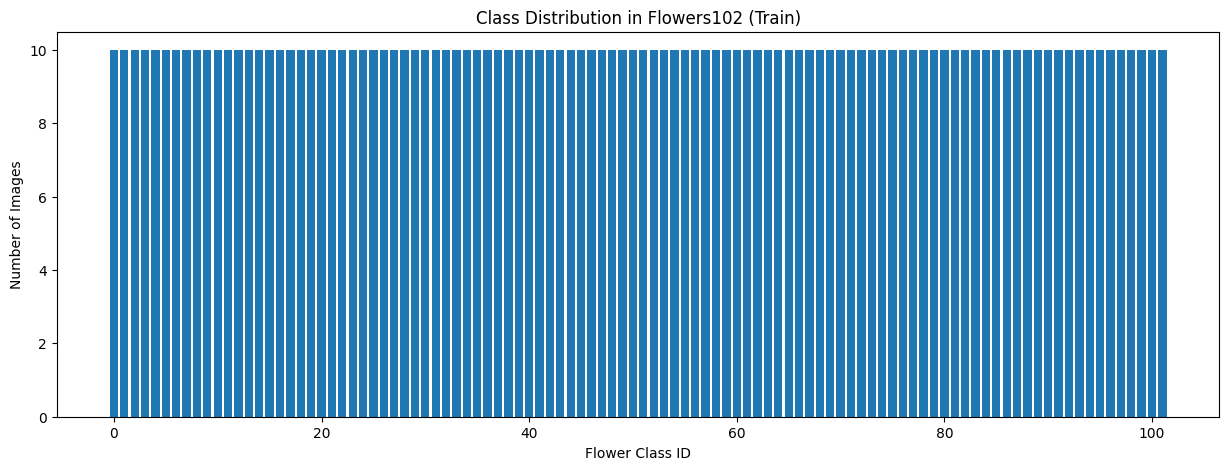

Min images in a class: 10
Max images in a class: 10


In [7]:
display_distribution(train_dataset,"Train")

Validation dataset class distribution


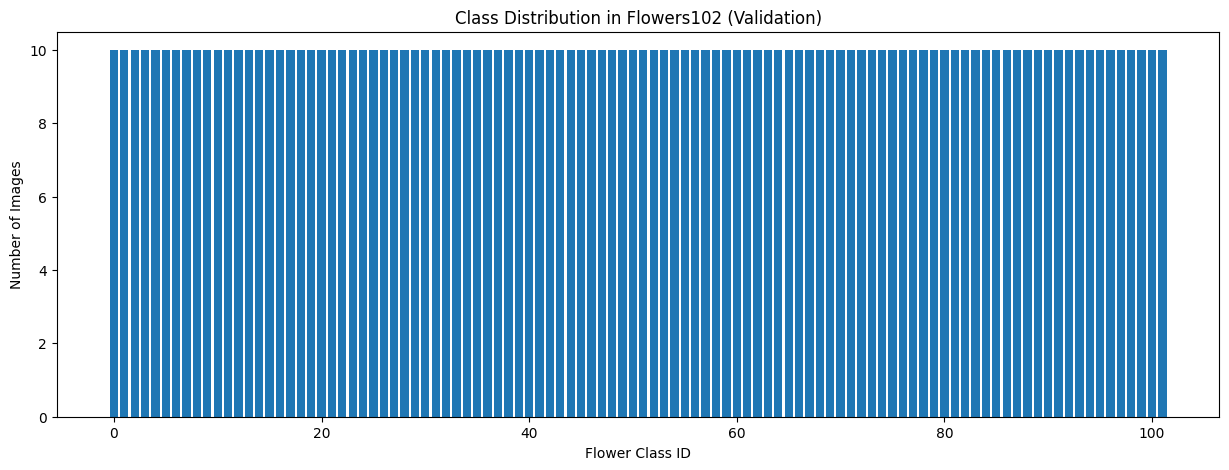

Min images in a class: 10
Max images in a class: 10


In [8]:
display_distribution(val_dataset,"Validation")

Testing dataset class distribution

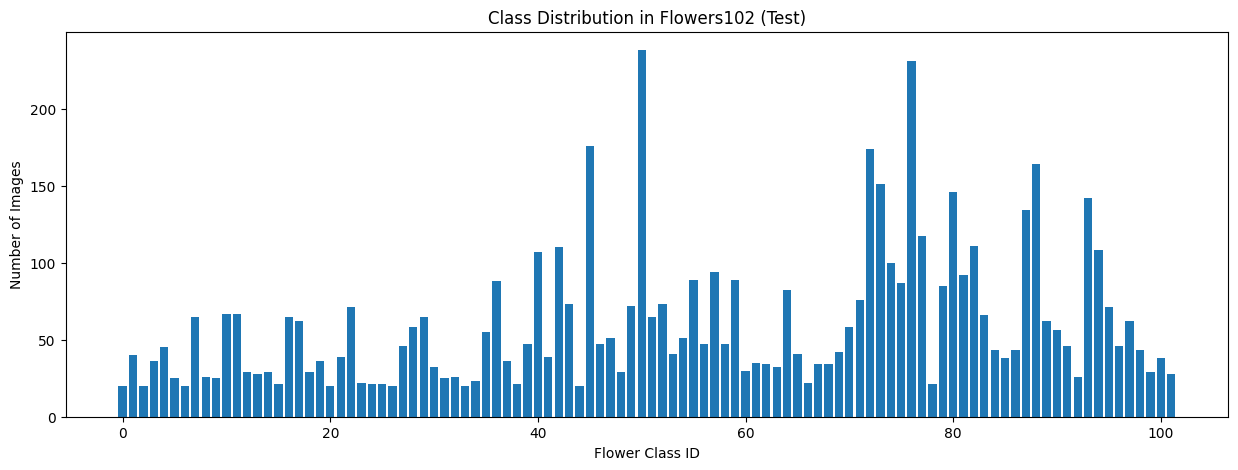

Min images in a class: 20
Max images in a class: 238


In [9]:
display_distribution(test_dataset,"Test")

Based on the above section, the training and validation show the same distribution. Thus the concern for class imbalances during training are none.
However, looking at the testing dataset, the class distribution are varied significantly.

As shown above, the min samples are 20 and max samples are 238. Therfore, let's try to display some of these samples


a) Top 5 classes with the highest samples:
The process are the same as the previous function. But after extracting the labels, most_common(5) is used to get the 5 most frequest classes.
Justification: getting the classes with the highest samples will help in identifying what techniques that can be applied into data augmentation, the metric that i need to focus instead just using accuracy.

In [11]:
test_labels = [label for _, label in test_dataset]
test_counts = Counter(test_labels)

top_5_highest = test_counts.most_common(5)
print("Top 5 classes with the highest number of samples:")
for class_id, count in top_5_highest:
    print(f"Class ID: {class_id}, Count: {count}")


Top 5 classes with the highest number of samples:
Class ID: 50, Count: 238
Class ID: 76, Count: 231
Class ID: 45, Count: 176
Class ID: 72, Count: 174
Class ID: 88, Count: 164


b) Top 5 classes with the lowest samples:
The process are the same as the previous function. But after extracting the labels, most_common() is used differently to get to the bottom 5.

In [14]:
top_5_lowest = test_counts.most_common()[-5:][::-1]
print("Top 5 classes with the lowest number of samples:")
for class_id, count in top_5_lowest:
    print(f"Class ID: {class_id}, Count: {count}")

Top 5 classes with the lowest number of samples:
Class ID: 44, Count: 20
Class ID: 33, Count: 20
Class ID: 26, Count: 20
Class ID: 20, Count: 20
Class ID: 6, Count: 20


Now let see some samples from both groups

### Samples from Top 5 Classes with Highest Samples

In [18]:
def show_sample_grid(dataset, class_id, n=5):
    samples = [img for img, lbl in dataset if lbl == class_id][:n]
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    if n == 1:
        axes = [axes] # Make it a list containing the single Axes object
    for i, img in enumerate(samples):
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.suptitle(f"Samples from Class {class_id}")
    plt.show()

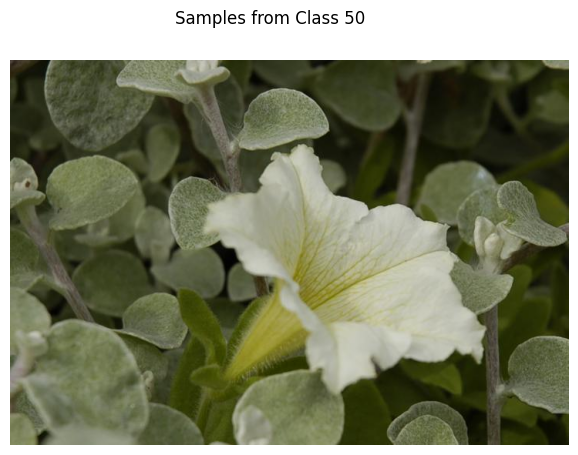

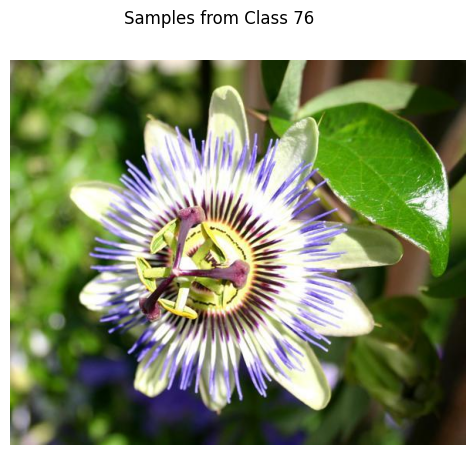

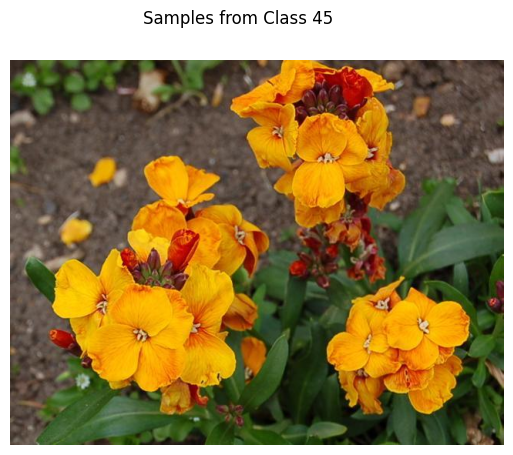

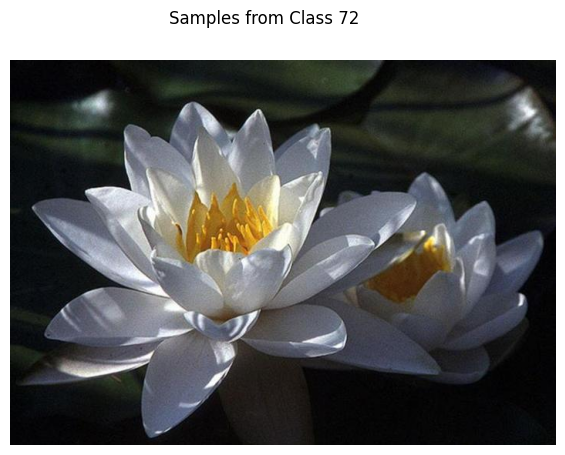

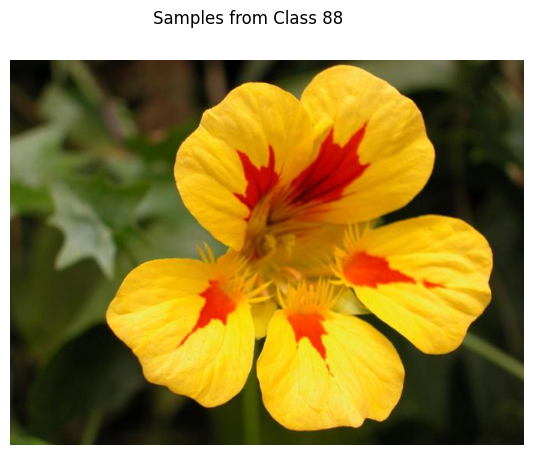

In [19]:
for class_id, _ in top_5_highest:
    show_sample_grid(test_dataset, class_id=class_id, n=1)

### Samples from Top 5 Classes with Lowest Samples

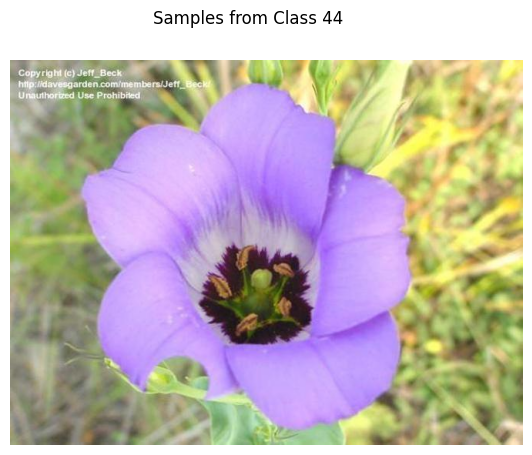

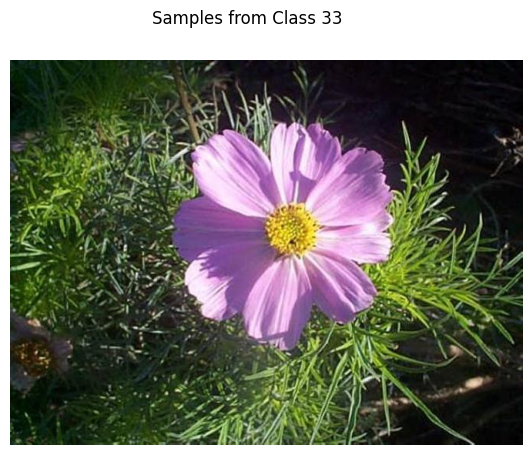

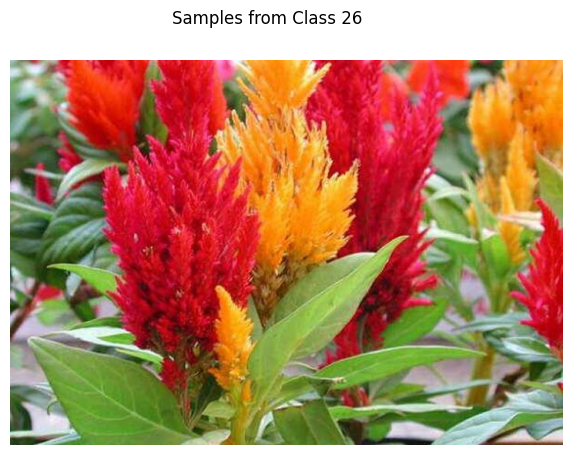

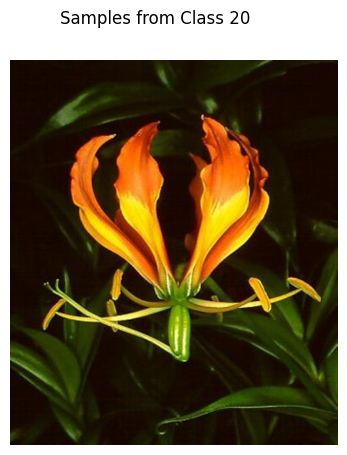

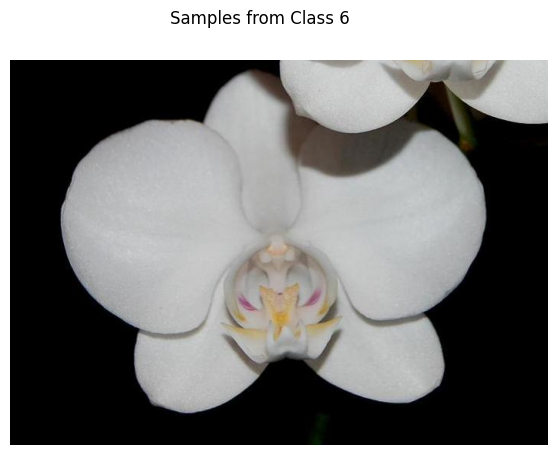

In [20]:
for class_id, _ in top_5_lowest:
    show_sample_grid(test_dataset, class_id=class_id, n=1)

### Conclusion:
Based on the samples display above, data augmentation needs to be heavy as the training dataset only consist of 10 samples from each class. Augmentation such as random rotation, flipping, and colour jitter are needed to increase the sample's variety.

However, with these classes, I will still expect some misclassification happen due to the sheer difference in the number of samples in the testing dataset.


### 3. Image Dimension and colour distribution

In this section, I will explore the image dimension and colour distribution.

In image dimension analysis, I need to check if the dataset has a mixed dimension. If it has, then I can employ image resizing and cropping to maintain the same dimension during training

As for colour distribution analysis, since the images are RGB, I will use RGB colour distribuition to identify if there are any colour imbalances.

### 3.1 Image Dimension Analysis

With image dimension, I'm looking into the size of the image itself whether the image dimension shows me they are taller or wider. By calculating the aspect ratio, I can identify if the image are wider/taller.

If they do exhibit those attributes, image resizing are needed to maintain the size of the image when training.

<p> Here I will do the analysis on the training dataset since the dataset is the one used for training. First the height and width for every image are extracted and store in a list.


Min width: 500
Max width: 919
Min height: 500
Max height: 993
Image dimension sample: Width = 500  Height = 598


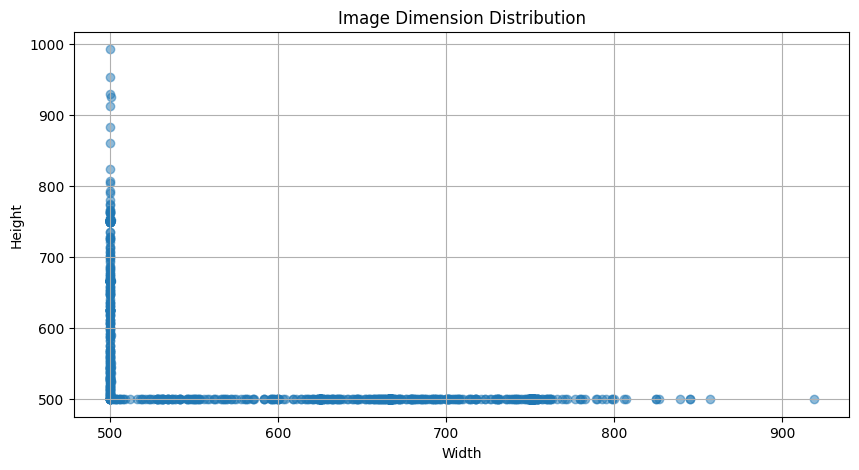

Mean Aspect Ratio: 1.19


In [25]:
widths, heights = [], []
for img, _ in train_dataset:
    w, h = img.size
    widths.append(w)
    heights.append(h)

print(f"Min width: {min(widths)}")
print(f"Max width: {max(widths)}")
print(f"Min height: {min(heights)}")
print(f"Max height: {max(heights)}")

print(f"Image dimension sample: Width = {widths[-1]}  Height = {heights[-1]}")

plt.figure(figsize=(10, 5))
plt.scatter(widths, heights, alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Image Dimension Distribution")
plt.grid(True)
plt.show()

# Calculate aspect ratios
aspect_ratios = np.array(widths) / np.array(heights)
print(f"Mean Aspect Ratio: {aspect_ratios.mean():.2f}")

Based on the above analysis, the aspect ratio of the training dataset shows that the images are close to square. Since the image dimension are not wide/tall that much, then manual imae resizing is not needed.

### 3.2 Colour distribution Analysis


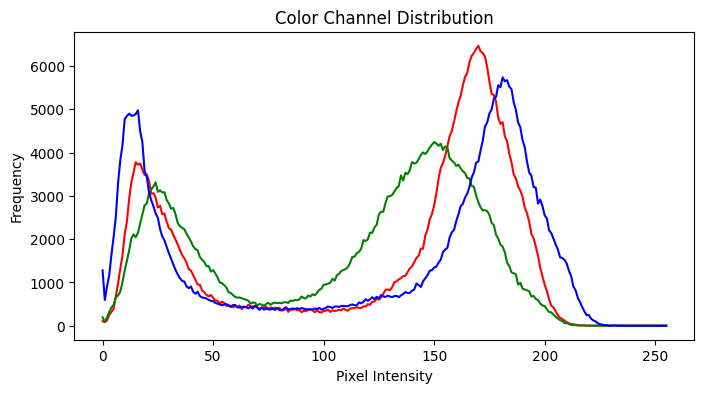

In [28]:
def plot_color_distribution(img):
    img_np = np.array(img)
    colors = ('r', 'g', 'b')
    plt.figure(figsize=(8, 4))
    for i, color in enumerate(colors):
        hist = np.histogram(img_np[:, :, i], bins=256, range=(0, 256))[0]
        plt.plot(hist, color=color)
    plt.title("Color Channel Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

# Analyze the first image
sample_img, _ = train_dataset[0]
plot_color_distribution(sample_img)

The figure above shows 2 peaks: one on the shadow/dark area and the other one in the bright area. This indicate a high contrast and lighting split. My concern will be if the flowers that the model is supposed to learn are in the middle low intensity area, then my model will struggle because of the background might overwhelme the object.

Since the contrast are quite clear, I will need to add normalization in my data augmentation and colour jitter to help balance the background and the object.